In [1]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import numpy as np
import pandas as pd
import cv2
from glob import glob



from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn.model_selection import GridSearchCV
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

TensorFlow 2.x selected.


In [2]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl
Kaggle API 1.5.6


In [3]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
import json
token = {'username':'aravindhrafa','key':'5cbba43517c60dfe9635cdd7bc2e5284'}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [5]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c plant-seedlings-classification

401 - Unauthorized


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
print(os.listdir('/content/drive/My Drive/image folder /train'))

# for accessing the files inside the google drive folder
# In the above line, image folder is saved with one space on the right side 

['Sugar beet', 'Shepherds Purse', 'Common wheat', 'Maize', 'Loose Silky-bent', 'Scentless Mayweed', 'Common Chickweed', 'Fat Hen', 'Cleavers', 'Black-grass', 'Charlock', 'Small-flowered Cranesbill']


In [0]:
types = ['Black-grass','Charlock','Cleavers','Common Chickweed','Common wheat','Fat Hen','Loose Silky-bent','Maize','Scentless Mayweed','Shepherds Purse','Small-flowered Cranesbill','Sugar beet']

total_data_path = '/content/drive/My Drive/image folder /'
train_path = os.path.join(total_data_path, 'train')
test_path = os.path.join(total_data_path, 'test')
sample_submission = pd.read_csv(os.path.join(total_data_path, 'sample_submission.csv'))

In [11]:
total_data_path

'/content/drive/My Drive/image folder /'

In [12]:
train_path

'/content/drive/My Drive/image folder /train'

In [13]:
test_path

'/content/drive/My Drive/image folder /test'

In [14]:
#Checking the segreation of each group of images like images.unique
# Since there are 12 folders containing the bulk of images

for i in types:

  p=len(os.listdir(os.path.join(train_path,i)))

  # Using the format method to collect the number of each types 

  # os.path is for finding the correct path 
  # Already train_path is correctly pointing the train path in gdrive
  # join () will help to point train_path ----> various types 

  print("{}              contains ----> {} images".format(i,p))


# File is accessed and datas are accessed 

Black-grass              contains ----> 263 images
Charlock              contains ----> 390 images
Cleavers              contains ----> 287 images
Common Chickweed              contains ----> 611 images
Common wheat              contains ----> 221 images
Fat Hen              contains ----> 475 images
Loose Silky-bent              contains ----> 654 images
Maize              contains ----> 221 images
Scentless Mayweed              contains ----> 516 images
Shepherds Purse              contains ----> 231 images
Small-flowered Cranesbill              contains ----> 506 images
Sugar beet              contains ----> 385 images


In [0]:
# To study about images of the train and their parameters, dataframe need to be created 


#dataframe with information on train dataset (made for convenient looping)
train = []
for p,q in enumerate(types):
  s = os.listdir(os.path.join(train_path,q))
  for x in s:
    train.append(['train/{}/{}'.format(q,x),q,p])


In [16]:

train_dataframe = pd.DataFrame(train,columns = ['train_file_path','plant_type','type_in_number'])
train_dataframe

,train_file_path,plant_type,type_in_number
0,train/Black-grass/0260cffa8.png,Black-grass,0
1,train/Black-grass/078eae073.png,Black-grass,0
2,train/Black-grass/0ace21089.png,Black-grass,0
3,train/Black-grass/0bb75ded8.png,Black-grass,0
4,train/Black-grass/0c67c3fc3.png,Black-grass,0
...,...,...,...
4755,train/Sugar beet/f474da0ca.png,Sugar beet,11
4756,train/Sugar beet/f9a842f5f.png,Sugar beet,11
4757,train/Sugar beet/faaac2544.png,Sugar beet,11
4758,train/Sugar beet/fb57ce659.png,Sugar beet,11


In [17]:
print(train_dataframe.shape)

(4760, 3)


In [18]:
test = []
for x in os.listdir(test_path):
  test.append(['test/{}'.format(x),x])

test_dataframe = pd.DataFrame(test,columns = ['file_path','plant_type'])
test_dataframe

,file_path,plant_type
0,test/0021e90e4.png,0021e90e4.png
1,test/003d61042.png,003d61042.png
2,test/01291174f.png,01291174f.png
3,test/00d090cde.png,00d090cde.png
4,test/00ef713a8.png,00ef713a8.png
...,...,...
789,test/fd87b36ae.png,fd87b36ae.png
790,test/fea3da57c.png,fea3da57c.png
791,test/fef2ade8c.png,fef2ade8c.png
792,test/ffc6f8527.png,ffc6f8527.png


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


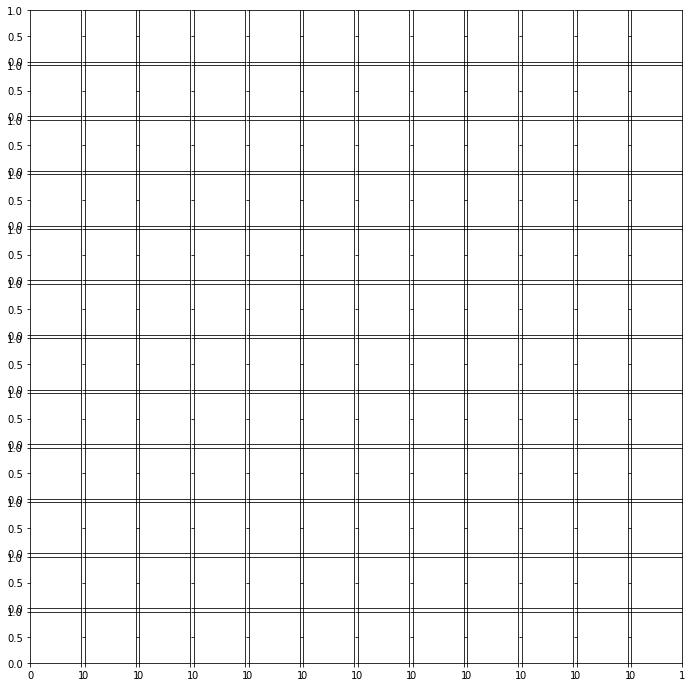

In [19]:
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import ImageGrid

size = len(types)
fig = plt.figure(1,figsize = (size,size))
grid_image = ImageGrid(fig,111,nrows_ncols = (size,size),axes_pad = 0.05)
i=0

for image_name,image_type in enumerate(types):
  for file_path in train_dataframe[train_dataframe['type_in_number'] == image_type]['train_file_path'].values[:size]:
    ax = grid_image[i]
    image  = Image.open(total_data_path+file_path)
    image = image.resize((240,240))
    ax.imshow(image)
    ax.axis('off')
    if i%size == size - 1:
      ax.text(250,113,file_path.split('/')[1], verticalalignment = 'center')
    i+1

plt.show()

In [20]:
from glob import glob
scale = 240
path_to_image_conversion = train_path+'/*/*.png'
image_collection = glob(path_to_image_conversion)
trainingset = []
traininglabels = []
num = len(image_collection)
count = 1
for i in image_collection:
  print(str(count)+'/'+str(num),end='/r')
  trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
  traininglabels.append(i.split('/')[-2])
  count = count+1

trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)



1/4760/r2/4760/r3/4760/r4/4760/r5/4760/r6/4760/r7/4760/r8/4760/r9/4760/r10/4760/r11/4760/r12/4760/r13/4760/r14/4760/r15/4760/r16/4760/r17/4760/r18/4760/r19/4760/r20/4760/r21/4760/r22/4760/r23/4760/r24/4760/r25/4760/r26/4760/r27/4760/r28/4760/r29/4760/r30/4760/r31/4760/r32/4760/r33/4760/r34/4760/r35/4760/r36/4760/r37/4760/r38/4760/r39/4760/r40/4760/r41/4760/r42/4760/r43/4760/r44/4760/r45/4760/r46/4760/r47/4760/r48/4760/r49/4760/r50/4760/r51/4760/r52/4760/r53/4760/r54/4760/r55/4760/r56/4760/r57/4760/r58/4760/r59/4760/r60/4760/r61/4760/r62/4760/r63/4760/r64/4760/r65/4760/r66/4760/r67/4760/r68/4760/r69/4760/r70/4760/r71/4760/r72/4760/r73/4760/r74/4760/r75/4760/r76/4760/r77/4760/r78/4760/r79/4760/r80/4760/r81/4760/r82/4760/r83/4760/r84/4760/r85/4760/r86/4760/r87/4760/r88/4760/r89/4760/r90/4760/r91/4760/r92/4760/r93/4760/r94/4760/r95/4760/r96/4760/r97/4760/r98/4760/r99/4760/r100/4760/r101/4760/r102/4760/r103/4760/r104/4760/r105/4760/r106/4760/r107/4760/r108/4760/r109/4760/r110/4760/r111/4760

error: ignored

In [0]:
trainingset

In [0]:
traininglabels

In [0]:
traininglabels[0]

In [0]:
new_train = []
sets = []
getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) 
        plt.subplot(2,3,2);plt.imshow(blurr) 
        plt.subplot(2,3,3);plt.imshow(hsv) 
        plt.subplot(2,3,4);plt.imshow(mask) 
        plt.subplot(2,3,5);plt.imshow(boolean) 
        plt.subplot(2,3,6);plt.imshow(new)
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
classes = enc.fit_transform(traininglabels)
print(classes.shape)
print(new_train.shape)

(2309,)


NameError: ignored

In [0]:
x_train,x_test,y_train,y_test = train_test_split(new_train,classes,test_size=0.20)

In [0]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape =([64,64,3])))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size= 5, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=128, kernel_size=5, activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Conv2D(filters=256, kernel_size= 5, activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size= 5, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [0]:
model1 = model.fit(x_train,y_train, epochs=100, validation_data=(x_test,y_test),batch_size=128,callbacks=[ModelCheckpoint(filepath=path_model)])

In [0]:
print(model1.evaluate(x_train, y_train))  
print(model1.evaluate(x_test, y_test)) 